# Subgraph Localization

**Author**: Amit Boyarski & Dani Kogan

## Intro

Let $\mathcal{G}$ be a graph with $n$ nodes, possibly directed, and let $\mathcal{G}_{sub}$ be another graph with $m<n$ nodes. 
Our problem is to find a subgraph of $\mathcal{G}$ which is as close as possible to $\mathcal{G}_{sub}$ according to some graph similarity metric $d(\mathcal{G}, \mathcal{G}_{sub})$.  For example, if $\mathcal{G}_{sub}$ consists of a subset of edges of $\mathcal{G}$ and their incident nodes, the problem is to identify those edges (from which the nodes could be identified). 

For simplicity we shall phrase the problem in terms of directly identifying the nodes rather than the edges. Any node identification algorithm can be turned into an edge identification algorithm by applying it to the *line graphs* of $\mathcal{G}$ and $\mathcal{G}_{sub}$.  We also phrase the algorithm in terms of undirected graphs. In order to account for the direction, we apply an invertible symmetrization to the graphs as a pre-process, e.g., transforming the directed graph into an undirected bipartite graph.
 
Let $\mathbf{w}$ denote a discrete probability distribution on the nodes of  $\mathcal{G}$, i.e., $0\leq w_i \leq 1$ satisfying $\sum_{i=1}^{n}{w_i} = 1$ is the probability for sampling the node $i$.  A vector $\mathbf{w}_{sub}$ representing the nodes of $\mathcal{G}_{sub}$ would be a uniform distribution on the nodes of $\mathcal{G}$ that is concentrated on the nodes of $\mathcal{G}_{sub}$, i.e., 

$$
\mathbf{w}_{sub}[i] = \begin{cases} 1/m &\;\;\;\;  i\in \mathcal{N}(\mathcal{G}_{sub})\\
 0 & \;\;\;\;otherwise.
 \end{cases}
$$
 
In order to optimize for $\mathbf{w}$, we define two functions:

- A node classification function $\texttt{classify}$ parametrized by $\theta$, which generates a vector $\mathbf{w}$ from $\mathcal{G}, \mathcal{G}_{sub}$, i.e.
$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub}; \theta)
$$

- A permutation invariant graph embedding function $\texttt{embed}$ parametrized by $\mathbf{\phi}$ which satisfies the following condition:

$$
$d\left(\texttt{embed}(\mathcal{G}, \mathbf{w}_{sub} ; \phi), $\texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1} ; \phi)\right) \approx 0  
$$

Our complete algorithm consists of two steps:

- *Training* : Shaping the graph metric 

$$
d\left(\texttt{embed}(\mathcal{G}_1, \mathbf{w}_1 ; \phi), $\texttt{embed}(\mathcal{G}_2, \mathbf{w}_2 ; \phi)\right)
$$

via supervised learning, e.g., learning $\phi$ via contrastive learning.

- *Inference*: Optimizing for $\theta$ given $\phi$:

$$
\mathbf{w} = \texttt{classify}(\mathcal{G}, \mathcal{G}_{sub} ; \theta)\\
\mathbf{v} = \texttt{embed}(\mathcal{G}, \mathbf{w}, ; \phi)\\
\mathbf{v}_{sub} = \texttt{embed}(\mathcal{G}_{sub}, 1/m\mathbf{1}, ; \phi)
$$

$$
\min_{\theta} d(\mathbf{v},\mathbf{v}_{sub})^2 + \rho \cdot \texttt{reg}(\mathcal{G}, \mathbf{w})
$$

The purpose of the $\texttt{reg}$ function is to promote $\mathbf{w}$ to be piecewise constant on the graph.

Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import torch

from common.graph_data_experiments_utils import get_map_keys_with_value_of, analyze_pairs_distances, load_dump_file_pairs_dataset
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import \
    EmbeddingMetricNetwork
from subgraph_matching_via_nn.composite_nn.composite_nn import CompositeNeuralNetwork
from subgraph_matching_via_nn.utils.utils import plot_indicator
from subgraph_matching_via_nn.graph_processors.graph_processors import GraphProcessor
from subgraph_matching_via_nn.data.data_loaders import load_graph
from subgraph_matching_via_nn.data.paths import *
from subgraph_matching_via_nn.data.paths import DATA_PATH
from subgraph_matching_via_nn.utils.plot_services import PlotServices
from subgraph_matching_via_nn.composite_nn.composite_solver import BaseCompositeSolver
from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_network_factory import \
    NodeClassifierNetworkFactory, NodeClassifierLastLayerType, NodeClassifierNetworkType
from subgraph_matching_via_nn.graph_embedding_networks.graph_embedding_network_factory import \
    GraphEmbeddingNetworkFactory, EmbeddingNetworkType
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import \
    binary_penalty, graph_entropy, spectral_reg, graph_total_variation, graph_nodes_number, graph_edges_number
from subgraph_matching_via_nn.mask_binarization.indicator_dsitribution_binarizer import IndicatorBinarizationType, \
    IndicatorDistributionBinarizer, IndicatorBinarizationBootType
from common.graph_data_experiments_utils import remove_isolated_nodes_from_graph
from subgraph_matching_via_nn.utils.utils import get_node_indicator, get_edge_indicator
from subgraph_matching_via_nn.data.sub_graph import SubGraph
from subgraph_matching_via_nn.graph_embedding_networks.gnn_embedding_network import GNNEmbeddingNetwork
from common.graph_data_experiments_utils import init_embedding_net_and_trainer
from powerful_gnns.models.graphcnn import GraphCNN
from subgraph_matching_via_nn.utils.utils import TORCH_DTYPE
from subgraph_matching_via_nn.composite_nn.composite_solver import PickleSupportedCompositeSolver
from subgraph_matching_via_nn.composite_nn.localization_state_replayer import ReplayableLocalizationState
from subgraph_matching_via_nn.training.PairSampleInfo import PairSampleBase
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph

plt.rcParams["figure.figsize"] = (6, 3)  # Set the desired figure size (width, height)

Load graph and subgraph

In [2]:
# Set the size of the graph and the subgraph
n_random = 10  # Number of nodes in the graph (for random graph)
m_random = 7  # Number of nodes in the subgraph (for random graph)

seed = 10  # for plotting
plot_services = PlotServices(seed)

loader_params = {'graph_size': n_random,
                 'subgraph_size': m_random,
                 'data_path' : DATA_PATH,
                 'g_full_path': COMP1_FULL_path,
                 'g_sub_path': COMP1_SUB0_path}

sub_graph = \
    load_graph(type='subcircuit',
               loader_params=loader_params) # type = 'random', 'example', 'subcircuit'
original_G = sub_graph.G
G = original_G

G_sub = sub_graph.G_sub

In [3]:
brute_force_model_folder_name = "1708724324.7261853" #hidden_dim=16 -> 1708724324.7261853

# load brute force experiment objects, including perturbed graph
dump_path = f"..{os.sep}notebooks{os.sep}brute_force_graph_objects.p"
with open(dump_path, 'rb') as file:
    brute_force_graph_objects = pickle.load(file)
brute_force_k_subgraph_annotated_graphs, brute_force_k_subgraphs, G, G_sub = brute_force_graph_objects

# remove(d) some nodes from full graph to minimize search space
k = len(G_sub)
n = len(sub_graph.G)
# candidate_nodes_to_remove_from_full_graph = list(set(sub_graph.G.nodes).difference(G_sub.nodes))
# G = sub_graph.G.copy()
# n_nodes_to_remove_from_full_graph = len(candidate_nodes_to_remove_from_full_graph) // 2
# G.remove_nodes_from(candidate_nodes_to_remove_from_full_graph[:n_nodes_to_remove_from_full_graph])
#
# remove_isolated_nodes_from_graph(G)

node_indicator = get_node_indicator(G=G, G_sub=G_sub)
edge_indicator, subgraph_adj_matrix = get_edge_indicator(G=G, G_sub=G_sub)
sub_graph = SubGraph(G, G_sub, edge_indicator=edge_indicator, node_indicator=node_indicator)
print(f"full graph has {n} nodes, subgraph has {k} nodes, removed {n - len(G)} non subgraph nodes from full graph")

full graph has 16 nodes, subgraph has 8 nodes, removed 4 non subgraph nodes from full graph


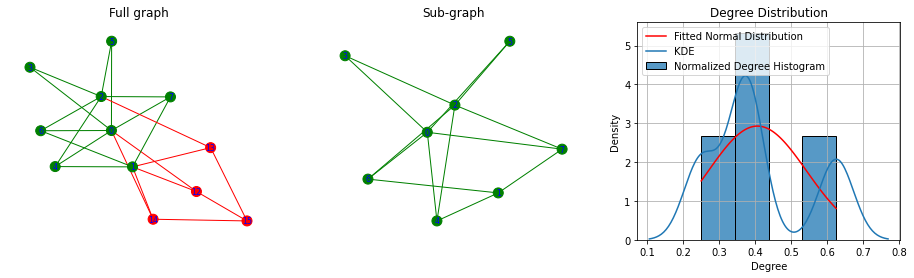

First 6 moments: ['0.4062', '0.1836', '0.0913', '0.0490', '0.0278', '0.0164']


In [4]:
plot_services.plot_graph_alongside_subgraph_with_degree_distribution(sub_graph, n_moments = 6)

Line graph transformation

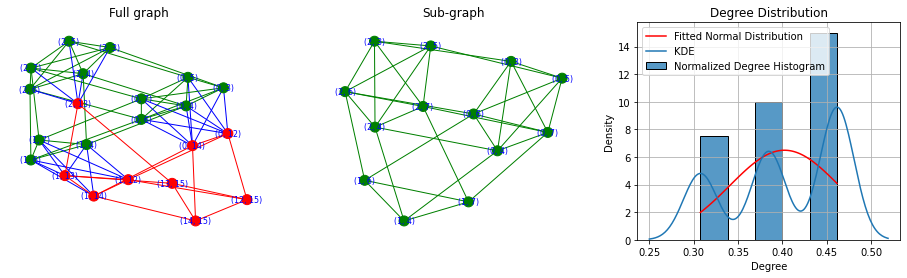

First 6 moments: ['0.4024', '0.1657', '0.0696', '0.0297', '0.0129', '0.0057']


In [5]:
to_line = True #TODO: True

graph_processor = GraphProcessor(params={'to_line':  to_line})#, 'to_undirected': 'symmetrize'})
processed_sub_graph = graph_processor.pre_process(sub_graph)

processed_G = processed_sub_graph.G

plot_services.plot_graph_alongside_subgraph_with_degree_distribution(processed_sub_graph, n_moments = 6)

In [6]:
# validate line graph transformation
assert set([list(processed_sub_graph.G.nodes)[i] for i, val in enumerate(processed_sub_graph.node_indicator) if val == 1]) == set(processed_sub_graph.G_sub.nodes)

Build localization network

In [7]:
def build_composite_solver(embedding_nns, embedding_metric_nn, node_classifier_network, graph_processor, params, device):
    composite_nn = CompositeNeuralNetwork(node_classifier_network=node_classifier_network,
                                      embedding_networks=embedding_nns,
                                      device=device)
    composite_solver = BaseCompositeSolver(composite_nn, embedding_metric_nn, graph_processor, params)

    return composite_solver, composite_nn

def load_pre_trained_gin_embedding(model_checkpoint_path):
    embedding_nns = []

    _, graph_metric_nn, model = init_embedding_net_and_trainer(model_factory_func, solver_params=solver_params, problem_params=None, graph_metric_nn_checkpoint_path=model_checkpoint_path, build_trainer=False) #1707912623.0225792 #16
    _ = graph_metric_nn.eval()
    embedding_nn = GNNEmbeddingNetwork(gnn_model=model, params=params)
    _ = embedding_nn.eval()
    embedding_nns.append(embedding_nn)

    return embedding_nns

In [45]:
from subgraph_matching_via_nn.subgraph_localization_algs.unconstrained_nonlinear_optimization import mask_boundaries

params = {}
params["solver_type"] = 'gd'
params["maxiter"] = 5000
params["lr"] = 1e-5 # 0.0002 is good
params["n_moments"] = 10
params["m"] = len(processed_sub_graph.G_sub.nodes())
params["n"] = len(processed_sub_graph.G_sub.edges())
params["k_update_plot"] = 250
params['spectral_op_type'] = 'Laplacian' # 'Laplacian'. 'Adjacency'
params["moment_type"] = "raw" #"standardized_raw"  # options: 'central' ,'raw', 'standardized_raw', 'standardized_central'
params['num_mid_layers'] = 10
params["reg_params"] = [1000, 0]  # reg param  # 0.02  is good
params["reg_terms"] = [binary_penalty, graph_edges_number]# #graph_total_variation] [spectral_reg] [graph_nodes_number, mask_boundaries]
# params["quantile_level"] = (params["n"]-params["m"])/params["m"]
params["graphcnn_hidden_dim"] = 512 #TODO:1024 #512#2048# 16 #2048# 256# 128
device = 'cpu' #TODO'cuda'
params['device'] = device
params['is_use_model_compliation'] = False  #Only supported for Pytorch > 2.0, and currently not supported on Windows
params['scaler'] = 1000#e+05 # scale down loss terms
params['apply_quantization'] = False
params['dynamic_metric_training_experiments_pace'] = 10

# NodeClassifierLastLayerType.SquaredNormalized for Moments
# Sigmoid/Identity/SquaredNormalized for GraphCNN, instead
#TODO: Sigmoid instead of Identity?

# NodeClassifierNetworkType.NN,
# TODO NodeClassifierNetworkType.NN/NodeClassifierNetworkType.GoogleSoftmax
node_classifier_network = NodeClassifierNetworkFactory.create_node_classifier_network(processed_G,
                                                                                      last_layer_type=NodeClassifierLastLayerType.Identity, node_classifier_network_type=NodeClassifierNetworkType.NN, params=params)
node_classifier_network.train_node_classifier(G_sub=processed_sub_graph.G_sub, graph_generator=None)

# Graph CNN model factory definition
# input dim matches the node mask (w) shape of (m, 1)
model_factory_func = lambda device: GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=1, hidden_dim=params["graphcnn_hidden_dim"], output_dim=1, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(dtype=TORCH_DTYPE)
params["graphcnn_factory_func"] = model_factory_func

solver_params = {
    "device": device,
    "lr": 1e-6, "weight_decay": 1e-3,
    "max_epochs": 1500, #TODO: 200_000,
    "model_checkpoint_epochs_pace": 40_000,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-3,
    "successive_convergence_min_iterations_amount": 5,
    "margin_loss_margin_value": 50,
    "max_grad_norm": 0.1,
    "batch_size": 512, #TODO
    "is_use_model_compliation": params['is_use_model_compliation'],
    "k_update_plot": 1,
    "train_monitoring_epochs_pace": 5,
    "scaler": 1,
}

solver_params['m'] = params['m']


use_non_trained_embeddings = True

# Build new embedding
if use_non_trained_embeddings:
    embedding_type = EmbeddingNetworkType.GraphCNN #Moments, Spectral, GraphCNN
    embedding_nns = GraphEmbeddingNetworkFactory.create_embedding_networks(sub_graph, params,
                                                                           [embedding_type])
    for embedding_nn in embedding_nns:
        _ = embedding_nn.eval()
else:
    # Or load pre trained embedding
    embedding_nns = load_pre_trained_gin_embedding(f"../notebooks/mp/{brute_force_model_folder_name}/best_model_state_dict.pt")

# prepare attributes for potential dump by dataloader of localization examples ->
# avoid using lambda functions, not stable on some platforms and torch version
params["graphcnn_factory_func"] = None


embedding_metric_nn = EmbeddingMetricNetwork(loss_fun=torch.nn.MSELoss(), params=params)
composite_solver, composite_nn = build_composite_solver(embedding_nns, embedding_metric_nn, node_classifier_network, graph_processor, params, device)

In [33]:
# from subgraph_matching_via_nn.graph_classifier_networks.node_classifier_networks import SequentialNodeClassifierNetwork
#
# node_classifier_network1 = NodeClassifierNetworkFactory.create_node_classifier_network(processed_G,
#                                                                                       last_layer_type=NodeClassifierLastLayerType.Identity, node_classifier_network_type=NodeClassifierNetworkType.NN, params=params)
# node_classifier_network2 = NodeClassifierNetworkFactory.create_node_classifier_network(processed_G,
#                                                                                       last_layer_type=NodeClassifierLastLayerType.SquaredNormalized, node_classifier_network_type=NodeClassifierNetworkType.GoogleSoftmax, params=params)
#
# node_classifier_network = SequentialNodeClassifierNetwork([node_classifier_network1, node_classifier_network2])

#### For the GraphCNN embedding, makes sure it was trained via brute forcing on all graphs

In [26]:
brute_force_train_samples_list = load_dump_file_pairs_dataset(f"..{os.sep}notebooks{os.sep}brute_force_pairs", n_partitions=8) #n_partitions=88

20829
18020
15211
12402
9593
6784
3975
1176


In [27]:
len(brute_force_train_samples_list)

87990

In [87]:
# positive_examples = [pair for pair in brute_force_train_samples_list if pair.is_negative_sample==False]
# positive_examples_graphs_labels = set([pair.subgraph.label for pair in positive_examples] + [pair.masked_graph.label for pair in positive_examples])
# positive_examples_graphs = [g for g in brute_force_k_subgraph_annotated_graphs if g.label in positive_examples_graphs_labels ]
# # why 372 choose 2 does not produce 2916? (if g1 is isomorphic to g2, and g2 to g3, then g1 should be to g3)
# # -> since each g1 has its own set of isomorphic graphs
# total_isomorphic_pairs_amount = 0
# for i, candidate_isomorphic_graph in enumerate(positive_examples_graphs):
#     candidate_g = candidate_isomorphic_graph.g.copy()
#     remove_isolated_nodes_from_graph(candidate_g)
#     for j in range(i+1, len(positive_examples_graphs)):
#         candidate_g2 = positive_examples_graphs[j].g.copy()
#         remove_isolated_nodes_from_graph(candidate_g2)
#         if nx.is_isomorphic(candidate_g2, candidate_g):
#             total_isomorphic_pairs_amount += 1
#
# # histogram of isomorphic pairs per k_subgraph
#
# k_subgraph_label_to_total_isomorphic_pairs_amount_map = {}
# k_subgraph_label_to_isomorphic_pairs_labels_map = {}
#
# for target_label, k_subgraph in enumerate(brute_force_k_subgraph_annotated_graphs):
#     if target_label in k_subgraph_label_to_total_isomorphic_pairs_amount_map:
#         # already counted by the isomorphic graph label
#         continue
#
#     isomorphic_pairs_amount = 0
#     target_k_subgraph = k_subgraph.g.copy()
#     remove_isolated_nodes_from_graph(target_k_subgraph)
#
#     isomorphic_graph_labels = []
#
#     for candidate_label, candidate_isomorphic_graph in enumerate(brute_force_k_subgraph_annotated_graphs):
#         if target_label == candidate_label:
#             continue
#
#         candidate_g = candidate_isomorphic_graph.g.copy()
#         remove_isolated_nodes_from_graph(candidate_g)
#         if nx.is_isomorphic(target_k_subgraph, candidate_g):
#             isomorphic_pairs_amount += 1
#             isomorphic_graph_labels.append(candidate_label)
#
#             # mark candidate in order to skip its future loop processing
#             k_subgraph_label_to_total_isomorphic_pairs_amount_map[candidate_label] = None
#
#     k_subgraph_label_to_total_isomorphic_pairs_amount_map[target_label] = isomorphic_pairs_amount
#     k_subgraph_label_to_isomorphic_pairs_labels_map[target_label] = isomorphic_graph_labels

In [88]:
# # show the min is achieved on the target graph
# graphs_without_isomorphic_pairs_labels = get_map_keys_with_value_of(k_subgraph_label_to_total_isomorphic_pairs_amount_map, 0)
# print(graphs_without_isomorphic_pairs_labels)
#
# target_k_subgraph_label = graphs_without_isomorphic_pairs_labels[0]
# target_graph = positive_examples_graphs[target_k_subgraph_label].g.copy() #G_sub.copy()
# remove_isolated_nodes_from_graph(target_graph)
#
# train_positive_distances, train_negative_distances = analyze_pairs_distances(trainer, graph_metric_nn, pairs=brute_force_train_samples_list, annotated_graphs=brute_force_k_subgraph_annotated_graphs, original_nodes_graphs=brute_force_k_subgraphs, target_label=target_k_subgraph_label, G_perturbed=G, solver_params={'margin_loss_margin_value': 0.2}, device=device)

In [89]:
# sorted(train_negative_distances)

Initialize the localization parameters

In [46]:
params['maxiter'] = 15_000
params['lr'] = 2e-5# try lr=8e-8 with reg node and edges penalty of 1 [0, 0, 1, 1] # 2e-03 #2e-07
# params['weight_decay'] = 1e-00#e-04
params['solver_type'] = 'gd' #"adam" #'lbfgs' #gd
binarization_type = IndicatorBinarizationType.TopK
series_binarization = IndicatorDistributionBinarizer.from_indicators_series_to_binary_indicator

solver_params['lr'] = 1e-6
params['scaler'] = 1e-03#e+3#8
params["reg_params"] = [0, 0]

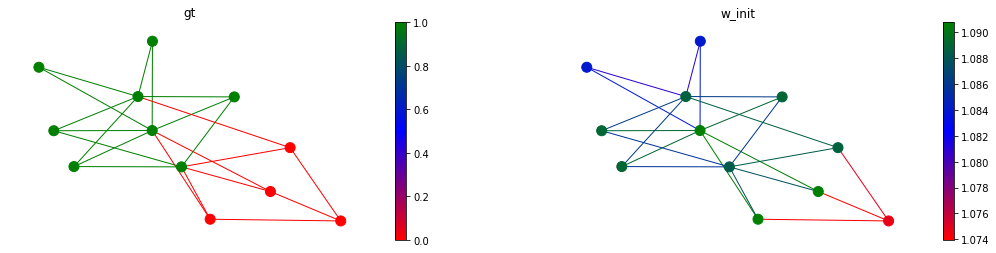

init loss (no reg): 17386.630166351984
init full loss (with reg): 17386.630166351984
ref loss (no reg): 1.0648888271933049e-35
ref full loss (with reg): 1.0648888271933049e-35


In [47]:
gt_indicator = sub_graph.edge_indicator if to_line else sub_graph.node_indicator
gt_indicator_tensor = composite_nn.init_network_with_indicator(processed_sub_graph)
w_init = composite_nn.classify(A=processed_sub_graph.A_full.to(device=device),
                                              params=params).detach().cpu().numpy()

plot_services.plot_subgraph_gt_vs_initial_indicators(sub_graph, processed_sub_graph, w_init, gt_indicator)

# compute loss and embedding at init
loss, ref_loss = composite_solver.compare(processed_sub_graph.A_full, processed_sub_graph.A_sub, gt_indicator_tensor, A_sub_indicator=None, print_embeddings=False)

In [48]:
w_init

array([[1.08762991],
       [1.0739646 ],
       [1.08905937],
       [1.09077549],
       [1.08396552],
       [1.09077549],
       [1.08584896],
       [1.08905937],
       [1.08094752],
       [1.08626858],
       [1.08396552],
       [1.08626858],
       [1.08584896],
       [1.08905937],
       [1.0739646 ],
       [1.07477293],
       [1.08584896],
       [1.08762991],
       [1.08626858],
       [1.08831473],
       [1.08873435],
       [1.08094752]])

Localization experiments

In [49]:
negative_examples = []
w_all = []
previous_model_output_path = None

In [50]:
params['dynamic_metric_training_experiments_pace'] = 10
num_rand_exp = 1#10 #TODO

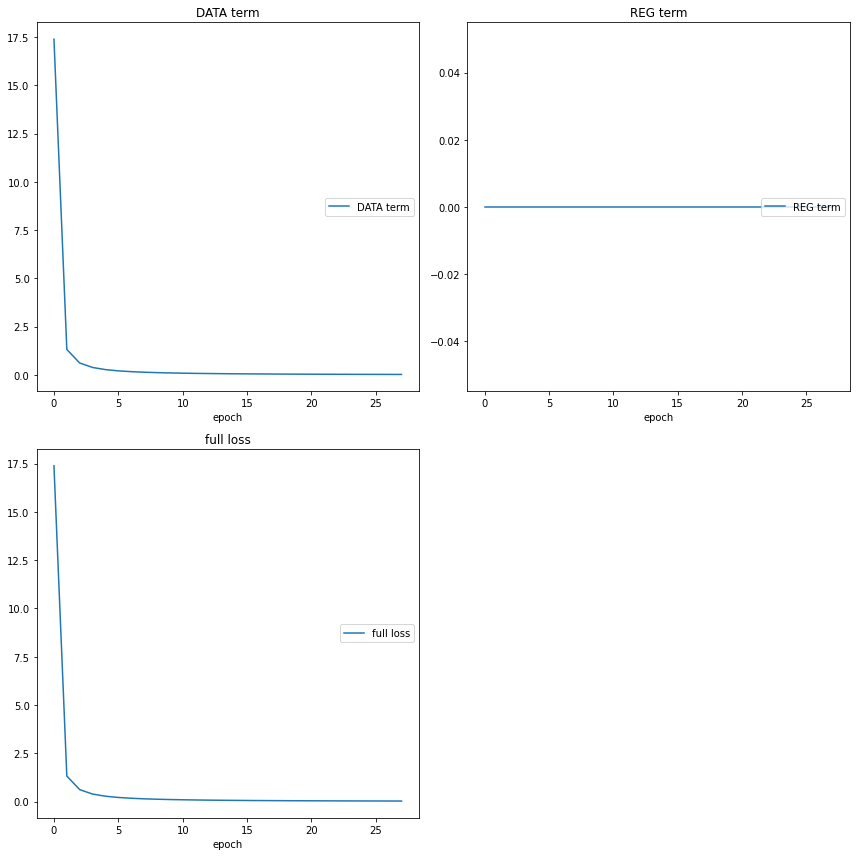

DATA term
	DATA term        	 (min:    0.028, max:   17.387, cur:    0.028)
REG term
	REG term         	 (min:    0.000, max:    0.000, cur:    0.000)
full loss
	full loss        	 (min:    0.028, max:   17.387, cur:    0.028)
Iteration 6750,
Data term: 0.027619439439384854
Reg: 0.0
Loss + Reg: 0.027619439439384854


KeyboardInterrupt: 

In [51]:
all_negative_examples_since_last_training = []
old_examples = []
if not use_non_trained_embeddings:
    old_examples = brute_force_train_samples_list

for k in range(1, num_rand_exp + 1):

    # _ = composite_nn.init_network_with_indicator(processed_sub_graph)
    composite_nn.node_classifier_network.init_params(default_weights=None)#TODO

    w_star = composite_solver.solve(G=sub_graph.G,
                             G_sub=sub_graph.G_sub, dtype=TORCH_DTYPE)

    # x0 = composite_solver.set_initial_params_based_on_previous_optimum(w_star) #TODO

    w_all.append(w_star)
    print(f"Finished solving iteration #{k}")

    # check for convergence
    if w_star is None:
        # no localization
        continue

    # binarization
    w_star_dict = dict(zip(processed_G.nodes(), w_star))
    w_bin_dict = series_binarization(processed_G, w_all, w_star, params, IndicatorBinarizationBootType.OptimalElement, binarization_type)
    w_rounded = torch.tensor(np.array(list(w_bin_dict.values())))

    # check if GT solution was found
    is_negative_example = (w_rounded != gt_indicator_tensor).any()
    if not is_negative_example:
        break

    print(f"rounded W = {w_rounded}")
    w_rounded = w_rounded.to(device=device)

    converged_subgraph = AnnotatedGraph(processed_sub_graph.G, label=None, node_attributes=w_rounded.reshape(-1), device=device)

    # collect negative + positive example pairs
    pair_sample_info = PairSampleBase(
        masked_graph = converged_subgraph,
        subgraph = AnnotatedGraph(processed_sub_graph.G_sub, label=None, device=device),
        is_negative_sample = is_negative_example,
        localization_state_object = ReplayableLocalizationState(processed_sub_graph, w_rounded)
    )

    negative_examples.append(pair_sample_info)
    all_negative_examples_since_last_training.append(pair_sample_info)

    if k % params['dynamic_metric_training_experiments_pace'] != 0:
        continue

    # re-training / fine-tuning
    old_examples += all_negative_examples_since_last_training

    # load updated model from last iteration
    trainer_composite_nn = CompositeNeuralNetwork(node_classifier_network=None,
                                  embedding_networks=[],
                                  device=device)
    trainer_composite_solver = PickleSupportedCompositeSolver(trainer_composite_nn, embedding_metric_nn, graph_processor, params)
    new_trainer, _, _ = init_embedding_net_and_trainer(model_factory_func, solver_params=solver_params, problem_params=None, graph_metric_nn_checkpoint_path=previous_model_output_path, build_trainer=True, composite_solver=trainer_composite_solver)

    _, previous_model_output_path = new_trainer.train(processes_device_ids=[device], use_existing_data_loaders=False, train_samples_list=old_examples, val_samples_list=old_examples, new_samples_amount=len(all_negative_examples_since_last_training))

    # recreate composite solver, as model has changed
    embedding_nns = load_pre_trained_gin_embedding(previous_model_output_path)
    composite_solver, composite_nn = build_composite_solver(embedding_nns, embedding_metric_nn, node_classifier_network, graph_processor, params, device)

    all_negative_examples_since_last_training = []

In [ ]:
is_negative_example

In [19]:
tmp_examples = brute_force_train_samples_list#[:100]
solver_params['max_epochs'] = 50
solver_params['lr'] = 1e-1

In [ ]:
# load updated model from last iteration
previous_model_output_path = None
trainer_composite_nn = CompositeNeuralNetwork(node_classifier_network=None,
                              embedding_networks=[],
                              device=device)
trainer_composite_solver = PickleSupportedCompositeSolver(trainer_composite_nn, embedding_metric_nn, graph_processor, params)
new_trainer, _, _ = init_embedding_net_and_trainer(model_factory_func, solver_params=solver_params, problem_params=None, graph_metric_nn_checkpoint_path=previous_model_output_path, build_trainer=True, composite_solver=trainer_composite_solver)

_, previous_model_output_path = new_trainer.train(processes_device_ids=[device], use_existing_data_loaders=False, train_samples_list=tmp_examples, val_samples_list=tmp_examples)

# recreate composite solver, as model has changed
embedding_nns = load_pre_trained_gin_embedding(previous_model_output_path)
composite_solver, composite_nn = build_composite_solver(embedding_nns, embedding_metric_nn, node_classifier_network, graph_processor, params, device)

Data loaders were built and saved locally


In [18]:
negative_examples_dump_path = f".{os.sep}localization_negative_examples.p"
#
# # save new examples locally
# with open(negative_examples_dump_path, 'wb') as file:
#     pickle.dump(negative_examples, file)

with open(negative_examples_dump_path, 'rb') as file:
    negative_examples = pickle.load(file)
    for negative_example in negative_examples:
        negative_example.localization_state_object.set_device(device)

In [19]:
for example_i in range(len(negative_examples)):
    for example_j in range(example_i+1, len(negative_examples)):
        print(f"{example_i} vs {example_j}, are equal? {np.isclose(negative_examples[example_i].masked_graph.node_indicator.detach().cpu().numpy(), negative_examples[example_j].masked_graph.node_indicator.detach().cpu().numpy(), atol=1e-5, rtol=0).all()}")

0 vs 1, are equal? False
0 vs 2, are equal? False
0 vs 3, are equal? False
1 vs 2, are equal? False
1 vs 3, are equal? False
2 vs 3, are equal? False


In [21]:
loss, ref_loss = composite_solver.compare(processed_sub_graph.A_full, processed_sub_graph.A_sub, w_rounded, A_sub_indicator=None)

[tensor([0.0000, 0.2022, 0.0000, 0.0000, 0.0000, 0.0509, 0.0000, 0.0000, 0.1000,
        0.0000, 0.0000, 0.1023, 0.0000, 0.0000, 0.0147, 0.0000, 0.0000, 0.0000,
        0.1003, 0.0304, 0.0000, 0.0000, 0.0623, 0.0058, 0.0246, 0.0000, 0.0000,
        0.0000, 0.0016, 0.0000, 0.0000, 0.0000], dtype=torch.float64,
       grad_fn=<UnbindBackward0>)] : init GNN
[tensor([0.0000, 0.2022, 0.0000, 0.0000, 0.0000, 0.0511, 0.0000, 0.0000, 0.1001,
        0.0000, 0.0000, 0.1025, 0.0000, 0.0000, 0.0149, 0.0000, 0.0000, 0.0000,
        0.1001, 0.0306, 0.0000, 0.0000, 0.0617, 0.0057, 0.0247, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)] : sub GNN
[tensor([0.0000, 0.2031, 0.0000, 0.0000, 0.0000, 0.0495, 0.0000, 0.0000, 0.1003,
        0.0000, 0.0000, 0.1016, 0.0000, 0.0000, 0.0141, 0.0000, 0.0000, 0.0000,
        0.1015, 0.0300, 0.0000, 0.0000, 0.0638, 0.0065, 0.0246, 0.0000, 0.0000,
        0.0000, 0.0010, 0.0000, 0.0000, 0.0000], dtype=torch.float64)] : GT GNN


In [49]:
len(negative_examples)

4

In [28]:
assert negative_examples[0].localization_state_object.w.sum().item() == 1

tensor(1., device='cuda:0', dtype=torch.float64)

In [ ]:
len(processed_sub_graph.G_sub.edges)

In [22]:
# check resulting mask
print(f"GT w: {gt_indicator_tensor.reshape(-1)}")

w_star_tensor = torch.tensor(w_star).reshape(-1)
print(f"converged w: {w_star_tensor}{os.linesep}")

print(f"~binary w: {w_star_tensor * params['m']}")
print(f"1/m= {1/params['m']}")
# from subgraph_matching_via_nn.mask_binarization.binarized_modules import binarized
# binarized_w_star = binarized(w_star_tensor, quant_mode="stochastic")

GT w: tensor([0.0000, 0.0000, 0.0769, 0.0000, 0.0769, 0.0000, 0.0769, 0.0769, 0.0769,
        0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0000, 0.0000, 0.0769, 0.0000,
        0.0769, 0.0000, 0.0000, 0.0769], dtype=torch.float64)
converged w: tensor([8.1328e-02, 8.6700e-03, 2.7095e-02, 1.1721e-01, 1.9002e-02, 3.8875e-02,
        1.1673e-01, 3.5072e-02, 1.0716e-02, 1.1752e-01, 5.5654e-02, 4.0632e-04,
        4.2071e-05, 1.6301e-02, 5.1325e-02, 6.2542e-03, 1.0887e-01, 3.7895e-02,
        6.7551e-02, 3.6235e-02, 2.0053e-03, 4.5249e-02], dtype=torch.float64)

~binary w: tensor([1.0573e+00, 1.1271e-01, 3.5223e-01, 1.5238e+00, 2.4703e-01, 5.0538e-01,
        1.5174e+00, 4.5593e-01, 1.3931e-01, 1.5277e+00, 7.2350e-01, 5.2822e-03,
        5.4692e-04, 2.1191e-01, 6.6723e-01, 8.1304e-02, 1.4153e+00, 4.9264e-01,
        8.7817e-01, 4.7105e-01, 2.6069e-02, 5.8823e-01], dtype=torch.float64)
1/m= 0.07692307692307693


Binarize output mask

In [ ]:
binarization_type = IndicatorBinarizationType.TopK
series_binarization = IndicatorDistributionBinarizer.from_indicators_series_to_binary_indicator

w_star = composite_nn.classify(A = processed_sub_graph.A_full.to(device=device), params = params).detach().cpu().numpy()
w_star_dict = dict(zip(processed_G.nodes(), w_star))

w_bin_dict = series_binarization(processed_G, w_all, w_star, params, IndicatorBinarizationBootType.OptimalElement, binarization_type)

w_boot_dict_bin = series_binarization(processed_G, w_all, w_star, params, IndicatorBinarizationBootType.SeriesNormalizedMean, binarization_type)

w_binarize_boot_dict = series_binarization(processed_G, w_all, w_star, params, IndicatorBinarizationBootType.SeriesMedianOfBinarizedElements, binarization_type)

w_gt_dict = dict(zip(processed_G.nodes(), gt_indicator_tensor))

indicator_name_to_object_map = {'w_star': w_star_dict, 'w_bin': w_bin_dict, 'w_boot_bin': w_boot_dict_bin, 'w_bin_boot': w_binarize_boot_dict, 'gt sub': w_gt_dict}
plot_services.plot_subgraph_indicators(G, to_line, indicator_name_to_object_map)

Compare indicators and their embeddings

In [ ]:
# BNN:

#https://github.com/itayhubara/BinaryNet.pytorch/blob/master/main_binary.py#L219
#https://github.com/jaygshah/Binary-Neural-Networks?tab=readme-ov-file
#https://arxiv.org/pdf/1812.11800.pdf
#optimizer needed: https://www.sciencedirect.com/science/article/abs/pii/S0925231223005544

In [ ]:
gt_node_distribution_processed = processed_sub_graph.w_gt
loss, ref_loss = composite_solver.compare(processed_sub_graph.A_full, processed_sub_graph.A_sub, gt_node_distribution_processed, A_sub_indicator=None, print_embeddings=False)
# print(f"{os.linesep}loss_ref = {ref_loss}, loss = {loss}")

In [ ]:
idx = 0 # to choose which embedding to plot

gt_node_distribution_processed = processed_sub_graph.w_gt
loss, ref_loss = composite_solver.compare(processed_sub_graph.A_full, processed_sub_graph.A_sub, gt_node_distribution_processed, A_sub_indicator=None)
indicator_name_to_object_map = {'est': w_star, 'est_bin': list(w_bin_dict.values()),
                                                       'est_boot_bin': list(w_boot_dict_bin.values()), 'est_bin_boot_bin': list(w_binarize_boot_dict.values())}
composite_solver.compare_indicators(processed_sub_graph.A_full, indicator_name_to_object_map, idx)

reg_terms_names = [reg_terms.__name__ for reg_terms in params['reg_terms']]

print(f"\n{to_line = }")
print(f"\nloss = {loss}, reg_params = {params['reg_params']}, reg_terms = {reg_terms_names}")
print(f"loss_ref = {ref_loss}, reg_param = {params['reg_params']}, reg_terms = {reg_terms_names}")
print(f"\nRemark: embeddings_gt and embeddings_sub might differ if we don't transform to line graph because node indicator can at best give a superset of the edges of the subgraph.")

plot_indicator([gt_node_distribution_processed, w_star, np.array(list(w_bin_dict.values()))], ['w_gt', 'w_star', 'w_bin'])

In [ ]:
for indicator_name, indicator_object in indicator_name_to_object_map.items():
    print(f"{os.linesep}{indicator_name}")
    loss, ref_loss = composite_solver.compare(processed_sub_graph.A_full, processed_sub_graph.A_sub, torch.tensor(list(indicator_object)), A_sub_indicator=None, print_embeddings=False)

    print(f"ref_loss={ref_loss.item()} vs loss={loss.item()}")